In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.define import *
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 16, 16)
# latt_size = (16, 16, 16, 32)
latt_size = (16, 16, 16, 16)
# latt_size = (16, 16, 8, 8)
# latt_size = (8, 8, 8, 16)
# latt_size = (8, 16, 16, 32)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
# latt_size = (2, 2, 2, 2)
# mass = -3.5
# mass = -0.8
# mass = -0.5
# mass = 0.05
# mass = 0.0
mass = -0.05
# kappa = 0.4
# kappa = 0.125
# kappa = 0.5
kappa = 1 / (2 * mass + 8)
dtype = torch.complex128
# dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_mg(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=24)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)
# clover_term = torch.zeros_like(clover_term) # just for test, just wilson

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
verbose = True
tol = 1e-6
max_iter = 1000

Using device: cuda


In [2]:
hopping_plus_list = []
hopping_minus_list = []
for ward in range(4):
    hopping_plus_list.append(wilson.give_hopping_plus(ward=ward, U=U))
    hopping_minus_list.append(wilson.give_hopping_minus(ward=ward, U=U))
Ab = wilson.give_wilson(src=b, U=U, with_I=False)
_Ab = torch.zeros_like(b)
for ward in range(4):
    _Ab += wilson.give_wilson_plus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_plus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
    _Ab += wilson.give_wilson_minus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_minus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
print(torch.norm(Ab-_Ab).item()/torch.norm(Ab).item())

2.159793231010612e-16


In [3]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U=U,
                clover=clover, clover_term=clover_term, tol=tol, max_iter=max_iter, verbose=verbose)
mg.init()

self.dof_list:[12, 24, 24, 24, 24]
Building grid list:
  Level 0: 16x16x16x16
  Level 1: 8x8x8x8
  Level 2: 4x4x4x4
  Level 3: 2x2x2x2
self.grid_list:[[16, 16, 16, 16], [8, 8, 8, 8], [4, 4, 4, 4], [2, 2, 2, 2]]
Norm of b:995.3552942777527
Norm of r:1406.9523673891347
Norm of x0:886.7027165587419
BICGSTAB-Iteration 0: Residual = 2.423532e+02, Time = 0.049943 s


BICGSTAB-Iteration 1: Residual = 7.992467e+01, Time = 0.048677 s
BICGSTAB-Iteration 2: Residual = 1.574924e+02, Time = 0.048916 s
BICGSTAB-Iteration 3: Residual = 2.681063e+01, Time = 0.048644 s
BICGSTAB-Iteration 4: Residual = 2.086307e+01, Time = 0.048674 s
BICGSTAB-Iteration 5: Residual = 1.178969e+01, Time = 0.048707 s
BICGSTAB-Iteration 6: Residual = 7.198665e+00, Time = 0.048706 s
BICGSTAB-Iteration 7: Residual = 1.260060e+01, Time = 0.048948 s
BICGSTAB-Iteration 8: Residual = 1.048705e+01, Time = 0.048725 s
BICGSTAB-Iteration 9: Residual = 6.744843e+00, Time = 0.048678 s
BICGSTAB-Iteration 10: Residual = 5.790636e+00, Time = 0.048638 s
BICGSTAB-Iteration 11: Residual = 4.429749e+00, Time = 0.048675 s
BICGSTAB-Iteration 12: Residual = 3.890145e+00, Time = 0.049031 s
BICGSTAB-Iteration 13: Residual = 3.303821e+00, Time = 0.048902 s
BICGSTAB-Iteration 14: Residual = 3.745100e+00, Time = 0.048792 s
BICGSTAB-Iteration 15: Residual = 2.071437e+00, Time = 0.048681 s
BICGSTAB-Iteration 

In [4]:
def matvec(src: torch.Tensor, U: torch.Tensor = U, clover_term: torch.Tensor = clover_term) -> torch.Tensor:
    return wilson.give_wilson(src, U)+clover.give_clover(clover_term=clover_term, src=src)


def _matvec(src: torch.Tensor) -> torch.Tensor:
    return mg.op_list[0].matvec(src=src)

In [5]:
%%time
%time Ab = matvec(b)
%time _Ab = _matvec(b)
print(torch.norm(U).item())
print(torch.norm(clover_term).item())
print(torch.norm(Ab).item())
print(torch.norm(_Ab).item())
print(torch.norm(Ab-_Ab).item()/torch.norm(_Ab).item())

CPU times: user 2.25 ms, sys: 63 μs, total: 2.31 ms
Wall time: 2.13 ms
CPU times: user 1.12 ms, sys: 0 ns, total: 1.12 ms
Wall time: 1.09 ms
886.8100134752651
42.71924944969692
995.0339592804646
995.0339592804646
1.7433398816555915e-16
CPU times: user 258 ms, sys: 74 μs, total: 258 ms
Wall time: 257 ms


In [6]:
%time Ab = matvec(b)
%time _Ab = _matvec(b)

CPU times: user 2.23 ms, sys: 0 ns, total: 2.23 ms
Wall time: 2.04 ms
CPU times: user 1.17 ms, sys: 0 ns, total: 1.17 ms
Wall time: 1.12 ms


In [7]:
b0 = mg.b_list[0]
b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
_b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
_b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
print(_b1.flatten()[:100]/b1.flatten()[:100])

restrict:shape,coarse_dof:(torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
prolong:shape,fine_dof:(torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
restrict:shape,coarse_dof:(torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
tensor([1.0000+1.0861e-16j, 1.0000+2.2107e-16j, 1.0000-1.7473e-16j,
        1.0000-3.5447e-16j, 1.0000+5.3059e-17j, 1.0000+7.0862e-18j,
        1.0000+1.5371e-16j, 1.0000+4.5575e-16j, 1.0000-2.1162e-16j,
        1.0000-2.5768e-16j, 1.0000-1.8215e-16j, 1.0000-2.9745e-16j,
        1.0000-8.1363e-17j, 1.0000-3.8012e-16j, 1.0000-2.9769e-16j,
        1.0000+1.3257e-16j, 1.0000+1.4584e-17j, 1.0000+2.6515e-16j,
        1.0000-2.8315e-16j, 1.0000+5.8799e-17j, 1.0000+6.7695e-17j,
        1.0000+1.4121e-15j, 1.0000-1.3366e-16j, 1.0000+6.1211e-17j,
        1.0000-7.0328e-17j, 1.0000+5.1557e-16j, 1.0000-2.7555e-16j,
        1.0000+1.1461e-16j, 1.0000-8.6589e-17j, 1.0000+7.4400e-17j,
        

In [8]:
_x = inverse.bicgstab(b=b, matvec=_matvec, tol=tol,
                      max_iter=max_iter, verbose=verbose)

Norm of b:886.9942300110736
Norm of r:1332.8023571545284
Norm of x0:886.406153412973
BICGSTAB-Iteration 0: Residual = 2.886100e+02, Time = 0.048836 s
BICGSTAB-Iteration 1: Residual = 1.267457e+02, Time = 0.049185 s
BICGSTAB-Iteration 2: Residual = 1.249156e+02, Time = 0.048789 s
BICGSTAB-Iteration 3: Residual = 8.380471e+01, Time = 0.048854 s
BICGSTAB-Iteration 4: Residual = 5.304314e+01, Time = 0.049126 s
BICGSTAB-Iteration 5: Residual = 1.539106e+02, Time = 0.049038 s
BICGSTAB-Iteration 6: Residual = 2.971276e+01, Time = 0.048874 s
BICGSTAB-Iteration 7: Residual = 2.334158e+01, Time = 0.048890 s
BICGSTAB-Iteration 8: Residual = 3.822538e+01, Time = 0.048882 s
BICGSTAB-Iteration 9: Residual = 3.087192e+01, Time = 0.048921 s
BICGSTAB-Iteration 10: Residual = 1.816187e+01, Time = 0.048895 s
BICGSTAB-Iteration 11: Residual = 1.629683e+01, Time = 0.048818 s
BICGSTAB-Iteration 12: Residual = 1.683456e+01, Time = 0.048842 s
BICGSTAB-Iteration 13: Residual = 1.454916e+01, Time = 0.048844 s
B

MG-0:Norm of b:886.9942300110736
MG-0:Norm of r:886.9942300110736
MG-0:Norm of x0:0.0
B-MG-0-BICGSTAB-Iteration 0: Residual = 2.286581e+02
restrict:shape,coarse_dof:(torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-1:Norm of b:133.3296339478921
MG-1:Norm of r:133.3296339478921
MG-1:Norm of x0:0.0
B-MG-1-BICGSTAB-Iteration 0: Residual = 4.975789e+01
restrict:shape,coarse_dof:(torch.Size([24, 24, 4, 2, 4, 2, 4, 2, 4, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-2:Norm of b:28.693480478040378
MG-2:Norm of r:28.693480478040378
MG-2:Norm of x0:0.0
B-MG-2-BICGSTAB-Iteration 0: Residual = 1.202837e+01
F-MG-2-BICGSTAB-Iteration 0: Residual = 1.202837e+01, Time = 0.002064 s
B-MG-2-BICGSTAB-Iteration 1: Residual = 6.749431e+00
F-MG-2-BICGSTAB-Iteration 1: Residual = 6.749431e+00, Time = 0.002020 s
B-MG-2-BICGSTAB-Iteration 2: Residual = 1.624405e+01
F-MG-2-BICGSTAB-Iteration 2: Residual = 1.624405e+01, Time = 0.002070 s
B-MG-2-BICGSTAB-Iteration 3: Residual = 4.963130e

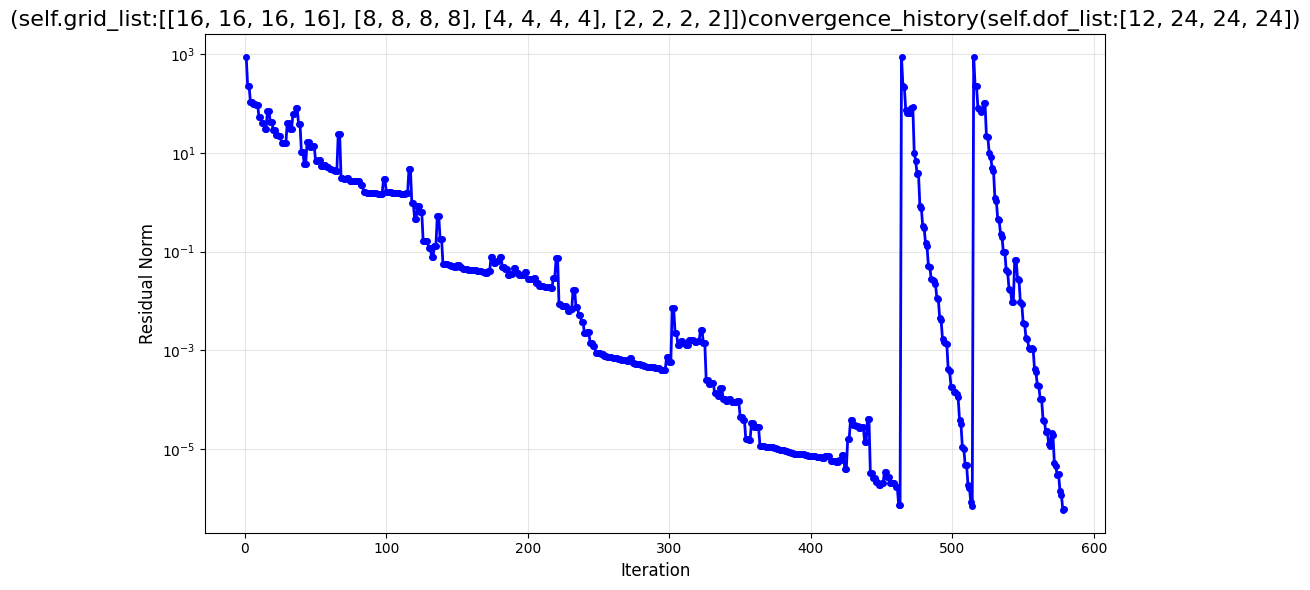

In [21]:
mg.num_levels = 3
x = mg.solve()
mg.plot()

In [10]:
mg.lonv_list[0].shape

torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2])

In [11]:
(mg.b_list[0]-mg.op_list[0].matvec(x.reshape([12]+list(x.shape[-4:])))).flatten()[:100]

tensor([-2.7650e-10+2.5668e-10j, -6.7422e-11+3.2989e-10j, -4.5573e-10+1.9684e-10j,
         4.4316e-11+4.7240e-10j, -2.5246e-10+2.1772e-10j,  1.0451e-10+3.6537e-10j,
        -2.9328e-10+2.5111e-10j, -1.0357e-10+3.5053e-10j, -2.3800e-10+3.1528e-10j,
        -2.9623e-11+3.5735e-10j, -2.0804e-10+4.5004e-10j, -1.2989e-10+4.9551e-10j,
        -3.2501e-10+4.6494e-10j, -1.2508e-10+5.1091e-10j, -2.9595e-10+4.8678e-10j,
        -8.2464e-11+4.1103e-10j, -1.4644e-10+2.6032e-10j, -3.0178e-10+8.1275e-11j,
        -1.2335e-10+3.1884e-10j, -2.9301e-10+9.9576e-11j,  3.0778e-11+2.6177e-10j,
        -2.2884e-10+2.8666e-10j, -6.8929e-11+2.8689e-10j, -1.4731e-10+3.4856e-10j,
        -1.3483e-11+2.7053e-10j, -2.0109e-10+1.9995e-10j, -4.0206e-11+3.5123e-10j,
        -2.7366e-10+3.3255e-10j, -2.1449e-10+3.2371e-10j, -3.1910e-10+3.9373e-10j,
        -3.2041e-10+3.9857e-10j, -2.8268e-10+2.6142e-10j, -2.3793e-10+2.1772e-10j,
        -1.1333e-10+2.6655e-10j, -2.2022e-10+1.2951e-10j, -1.2973e-10+4.7417e-11j,
    

In [12]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

6.622334300824543e-08


In [13]:
mg.num_levels

1

In [14]:
index = 0
null_vecs = mg.nv_list[index]
matvec = mg.op_list[index].matvec
for i in range(null_vecs.shape[0]):
    print(
        f"(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:{(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]}")

(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0025+4.4545e-03j, 0.0023+2.8657e-03j, 0.0016+1.6312e-03j,
        0.0017-8.2394e-05j, 0.0036-1.4098e-05j, 0.0054-1.1499e-04j,
        0.0056-1.4688e-04j, 0.0087+9.9428e-04j, 0.0102-3.6258e-04j,
        0.0142+2.1335e-03j], device='cuda:0', dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0094+0.0052j, 0.0092+0.0085j, 0.0076+0.0090j, 0.0066+0.0127j,
        0.0060+0.0122j, 0.0047+0.0149j, 0.0068+0.0155j, 0.0040+0.0164j,
        0.0057+0.0142j, 0.0070+0.0140j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([-0.0129-0.0106j, -0.0162-0.0076j, -0.0143-0.0119j, -0.0172-0.0144j,
        -0.0145-0.0091j, -0.0135-0.0192j, -0.0142-0.0123j, -0.0036-0.0142j,
        -0.0063-0.0118j, -0.0060-0.0090j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0061+0.0008j, 0.0073+0.0009j, 0.0057

In [15]:
mg.nv_list[-1].flatten()[:100]

tensor([-0.0117-8.8412e-04j, -0.0124-8.3377e-04j,  0.0087-1.6221e-03j,
        -0.0105-3.0575e-04j,  0.0070+2.2529e-03j, -0.0088-1.2564e-03j,
        -0.0061-7.3251e-04j, -0.0068-1.0922e-03j, -0.0073-2.4655e-03j,
        -0.0081-1.8872e-03j, -0.0059-5.0892e-04j, -0.0054-8.2688e-04j,
        -0.0114-3.0711e-03j, -0.0102-2.0353e-03j, -0.0090-8.6441e-04j,
         0.0095+1.6740e-04j, -0.0133+1.9735e-03j, -0.0120+3.4362e-03j,
        -0.0099+3.0983e-03j, -0.0103+1.8485e-03j, -0.0086-4.1372e-04j,
         0.0083-2.1058e-03j, -0.0066+3.8350e-03j,  0.0066-1.5397e-03j,
        -0.0074-6.1779e-04j, -0.0073+1.5702e-03j, -0.0059+2.8747e-03j,
        -0.0063+5.0051e-04j, -0.0115-4.9389e-04j,  0.0113-1.2053e-03j,
        -0.0096+2.6114e-03j, -0.0100+1.5672e-03j, -0.0121+1.9279e-03j,
         0.0105-4.3690e-03j, -0.0097+5.1807e-03j, -0.0119+3.3197e-03j,
        -0.0078+1.2652e-03j, -0.0073+3.1344e-03j, -0.0057+4.3000e-03j,
        -0.0073+2.0793e-03j,  0.0069-8.7713e-04j,  0.0059-2.9302e-03j,
      

In [16]:
_null_vec = torch.randn_like(null_vecs[0])
print(torch.norm(matvec(_null_vec)))
print(matvec(_null_vec).flatten()[:20])
_null_vec -= inverse.bicgstab(b=matvec(_null_vec), matvec=matvec, tol=5e-5)
print(torch.norm(_null_vec))
print(_null_vec.flatten()[:20])
_null_vec/=torch.norm(_null_vec).item()
print(
    f"(matvec(_null_vec)/_null_vec).flatten()[:10]:{(matvec(_null_vec)/_null_vec).flatten()[:10]}")

tensor(996.2699, device='cuda:0', dtype=torch.float64)
tensor([-1.5224+0.1974j, -0.0235+0.7412j, -0.2283-0.8739j, -0.6141+1.5909j,
         0.2004-0.0669j, -0.0872-0.7554j,  0.3914-0.2550j,  0.3031-0.5108j,
        -0.5740-0.2022j, -0.3499-0.3044j, -1.1797-0.5178j,  1.7831-0.8968j,
        -1.6398+0.1959j,  0.8352+0.4443j, -0.5559-0.5721j,  1.0357+0.1604j,
         1.0953-0.1909j, -0.7026+1.3594j,  1.0967-0.7519j,  1.0576+0.6987j],
       device='cuda:0', dtype=torch.complex128)
Norm of b:996.2699406824439
Norm of r:1408.919902222698
Norm of x0:887.5483329882467
BICGSTAB-Iteration 0: Residual = 2.426724e+02, Time = 0.048719 s
BICGSTAB-Iteration 1: Residual = 7.995931e+01, Time = 0.048819 s
BICGSTAB-Iteration 2: Residual = 1.575293e+02, Time = 0.048952 s
BICGSTAB-Iteration 3: Residual = 2.684975e+01, Time = 0.048960 s
BICGSTAB-Iteration 4: Residual = 2.250957e+01, Time = 0.048727 s
BICGSTAB-Iteration 5: Residual = 1.183274e+01, Time = 0.048734 s
BICGSTAB-Iteration 6: Residual = 8.125699

In [17]:
_b = torch.randn_like(null_vecs[0])
_x = inverse.bicgstab(b=_b, matvec=matvec, tol=1e-8)
print((_b-matvec(_x)).flatten()[:100])
print(torch.norm(_b))
print(torch.norm(_x))

Norm of b:887.8587303968645
Norm of r:1334.9503405967264
Norm of x0:887.970189110443
BICGSTAB-Iteration 0: Residual = 2.887691e+02, Time = 0.048709 s
BICGSTAB-Iteration 1: Residual = 1.304258e+02, Time = 0.049013 s
BICGSTAB-Iteration 2: Residual = 1.243111e+02, Time = 0.048777 s
BICGSTAB-Iteration 3: Residual = 8.372750e+01, Time = 0.048929 s
BICGSTAB-Iteration 4: Residual = 5.268672e+01, Time = 0.048898 s
BICGSTAB-Iteration 5: Residual = 5.008311e+01, Time = 0.048976 s
BICGSTAB-Iteration 6: Residual = 3.172444e+01, Time = 0.048875 s
BICGSTAB-Iteration 7: Residual = 2.757638e+01, Time = 0.048764 s
BICGSTAB-Iteration 8: Residual = 2.154854e+01, Time = 0.048934 s
BICGSTAB-Iteration 9: Residual = 3.890325e+01, Time = 0.048986 s
BICGSTAB-Iteration 10: Residual = 2.476241e+01, Time = 0.049053 s
BICGSTAB-Iteration 11: Residual = 2.275196e+01, Time = 0.048985 s
BICGSTAB-Iteration 12: Residual = 3.357638e+01, Time = 0.048833 s
BICGSTAB-Iteration 13: Residual = 8.319298e+01, Time = 0.048979 s
B

In [18]:
_null_vec.flatten()[:100]

tensor([0.0008+0.0014j, 0.0010+0.0012j, 0.0008+0.0014j, 0.0010+0.0011j,
        0.0011+0.0011j, 0.0010+0.0012j, 0.0009+0.0012j, 0.0009+0.0011j,
        0.0008+0.0013j, 0.0010+0.0012j, 0.0009+0.0011j, 0.0009+0.0011j,
        0.0011+0.0011j, 0.0012+0.0011j, 0.0011+0.0012j, 0.0009+0.0010j,
        0.0007+0.0013j, 0.0009+0.0011j, 0.0010+0.0011j, 0.0011+0.0011j,
        0.0010+0.0011j, 0.0010+0.0012j, 0.0010+0.0012j, 0.0010+0.0012j,
        0.0009+0.0013j, 0.0010+0.0012j, 0.0010+0.0012j, 0.0009+0.0012j,
        0.0010+0.0012j, 0.0010+0.0013j, 0.0010+0.0012j, 0.0011+0.0011j,
        0.0009+0.0013j, 0.0007+0.0012j, 0.0010+0.0012j, 0.0011+0.0013j,
        0.0012+0.0011j, 0.0011+0.0010j, 0.0010+0.0012j, 0.0010+0.0014j,
        0.0010+0.0014j, 0.0011+0.0013j, 0.0010+0.0014j, 0.0010+0.0013j,
        0.0011+0.0012j, 0.0009+0.0012j, 0.0009+0.0013j, 0.0009+0.0013j,
        0.0011+0.0012j, 0.0012+0.0012j, 0.0010+0.0012j, 0.0010+0.0012j,
        0.0010+0.0012j, 0.0011+0.0011j, 0.0009+0.0012j, 0.0008+0

In [19]:
mg.lonv_list[1].flatten()[:100]

tensor([-0.0745+0.0596j, -0.0770+0.0590j, -0.0803+0.0465j, -0.0692+0.0433j,
        -0.0711+0.0474j,  0.0683-0.0468j, -0.0759+0.0501j, -0.0704+0.0551j,
         0.0687-0.0519j,  0.0822-0.0523j, -0.0671+0.0463j, -0.0715+0.0479j,
        -0.0804+0.0462j,  0.0758-0.0422j, -0.0839+0.0428j, -0.0788+0.0459j,
        -0.0745+0.0540j,  0.0796-0.0501j, -0.0728+0.0433j, -0.0773+0.0534j,
        -0.0759+0.0390j,  0.0861-0.0381j, -0.0924+0.0495j, -0.0841+0.0464j,
        -0.0749+0.0479j,  0.0831-0.0490j, -0.0849+0.0444j, -0.0797+0.0400j,
        -0.0718+0.0384j, -0.0767+0.0479j, -0.0802+0.0528j, -0.0773+0.0519j,
        -0.0826+0.0562j,  0.0834-0.0463j, -0.0772+0.0437j,  0.0793-0.0451j,
        -0.0728+0.0503j, -0.0753+0.0526j, -0.0842+0.0460j, -0.0825+0.0538j,
        -0.0805+0.0661j,  0.0746-0.0523j,  0.0775-0.0468j,  0.0749-0.0499j,
        -0.0743+0.0468j, -0.0711+0.0526j, -0.0708+0.0454j, -0.0803+0.0576j,
        -0.0795+0.0605j,  0.0646-0.0477j, -0.0686+0.0472j, -0.0689+0.0443j,
        -0.0